# Feature Selection With Mutual Information Score

In [1]:
from warnings import filterwarnings 
filterwarnings('ignore')

In [2]:
import pandas as pd 
df = pd.read_csv('train_titanic.csv')
df.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 12 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   PassengerId  891 non-null    int64  
 1   Survived     891 non-null    int64  
 2   Pclass       891 non-null    int64  
 3   Name         891 non-null    object 
 4   Sex          891 non-null    object 
 5   Age          714 non-null    float64
 6   SibSp        891 non-null    int64  
 7   Parch        891 non-null    int64  
 8   Ticket       891 non-null    object 
 9   Fare         891 non-null    float64
 10  Cabin        204 non-null    object 
 11  Embarked     889 non-null    object 
dtypes: float64(2), int64(5), object(5)
memory usage: 83.7+ KB


In [4]:
s = df.isna().sum()
s

PassengerId      0
Survived         0
Pclass           0
Name             0
Sex              0
Age            177
SibSp            0
Parch            0
Ticket           0
Fare             0
Cabin          687
Embarked         2
dtype: int64

In [5]:
s[s>0]

Age         177
Cabin       687
Embarked      2
dtype: int64

In [6]:
df.duplicated().sum()

0

## Seperate X and Y Feature

In [7]:
X = df.drop(columns=['PassengerId', 'Name', 'Ticket', 'Cabin', 'Survived'])
Y = df[['Survived']]

In [8]:
X.head()

,Pclass,Sex,Age,SibSp,Parch,Fare,Embarked
0,3,male,22.0,1,0,7.2500,S
1,1,female,38.0,1,0,71.2833,C
2,3,female,26.0,0,0,7.9250,S
3,1,female,35.0,1,0,53.1000,S
4,3,male,35.0,0,0,8.0500,S


In [9]:
Y.head()

,Survived
0,0
1,1
2,1
3,1
4,0


### Seperate categorical and continous 

In [10]:
cat = list(X.columns[X.dtypes=='object'])
con = list(X.columns[X.dtypes!='object'])

In [11]:
cat

['Sex', 'Embarked']

In [12]:
con

['Pclass', 'Age', 'SibSp', 'Parch', 'Fare']

## Apply Preprocessing on X feature
cat - OrdinalEncoding

In [13]:
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler, OrdinalEncoder
from sklearn.impute import SimpleImputer
from sklearn.compose import ColumnTransformer 

In [14]:
num_pipe = Pipeline(steps=[('impute',SimpleImputer(strategy='median')),
                           ('scaler',StandardScaler())])
cat_pipe = Pipeline(steps=[('impute',SimpleImputer(strategy='most_frequent')),
                           ('ordinal',OrdinalEncoder())])
pre = ColumnTransformer([('num',num_pipe,con),('cat',cat_pipe,cat)]).set_output(transform='pandas')

In [15]:
X_pre = pre.fit_transform(X)
X_pre.head()

,num__Pclass,num__Age,num__SibSp,num__Parch,num__Fare,cat__Sex,cat__Embarked
0,0.827377,-0.565736,0.432793,-0.473674,-0.502445,1.0,2.0
1,-1.566107,0.663861,0.432793,-0.473674,0.786845,0.0,0.0
2,0.827377,-0.258337,-0.474545,-0.473674,-0.488854,0.0,2.0
3,-1.566107,0.433312,0.432793,-0.473674,0.420730,0.0,2.0
4,0.827377,0.433312,-0.474545,-0.473674,-0.486337,1.0,2.0


### Visualise Mutual Information Scores

In [16]:
from sklearn.feature_selection import mutual_info_classif
mi = mutual_info_classif(X_pre, Y)
mi

array([0.02520641, 0.        , 0.04082524, 0.        , 0.13702375,
       0.13624697, 0.        ])

In [17]:
mi = pd.Series(mi)
mi.index = X_pre.columns
mi = mi.sort_values(ascending=False)
mi

num__Fare        0.137024
cat__Sex         0.136247
num__SibSp       0.040825
num__Pclass      0.025206
num__Age         0.000000
num__Parch       0.000000
cat__Embarked    0.000000
dtype: float64

<Axes: title={'center': 'Mutual Information Scores'}>

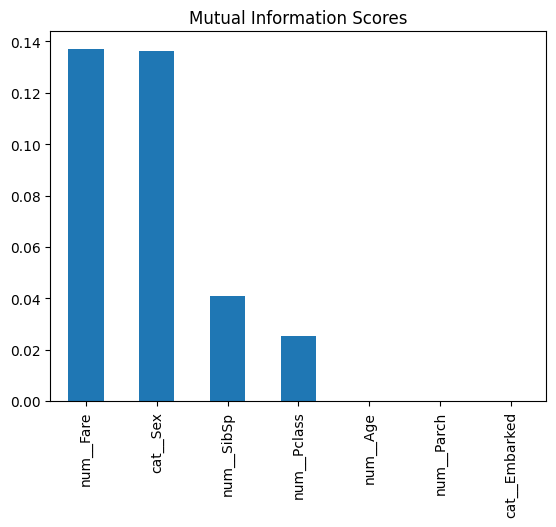

In [18]:
mi.plot(kind='bar',title='Mutual Information Scores')

### Select Top K features

In [19]:
from sklearn.feature_selection import SelectKBest
sel = SelectKBest(mutual_info_classif, k=5)
sel_feat = sel.fit_transform(X_pre, Y)
sel_col = sel.get_feature_names_out()
sel_col

array(['num__Pclass', 'num__Parch', 'num__Fare', 'cat__Sex',
       'cat__Embarked'], dtype=object)

In [20]:
sel_col[0]

'num__Pclass'

In [21]:
sel_col[0].split('__')

['num', 'Pclass']

In [22]:
sel_col[0].split('__')[1]

'Pclass'

In [23]:
imp_cols = []
for i in sel_col:
    s = i.split('__')[1]
    imp_cols.append(s)

In [24]:
imp_cols

['Pclass', 'Parch', 'Fare', 'Sex', 'Embarked']

In [25]:
x_imp = X[imp_cols]
x_imp

,Pclass,Parch,Fare,Sex,Embarked
0,3,0,7.2500,male,S
1,1,0,71.2833,female,C
2,3,0,7.9250,female,S
3,1,0,53.1000,female,S
4,3,0,8.0500,male,S
...,...,...,...,...,...
886,2,0,13.0000,male,S
887,1,0,30.0000,female,S
888,3,2,23.4500,female,S
889,1,0,30.0000,male,C


### Seperate cat and con seperator on  x_imp

In [26]:
cat_sel = list(x_imp.columns[x_imp.dtypes=='object'])
con_sel = list(x_imp.columns[x_imp.dtypes!='object'])

In [27]:
cat_sel

['Sex', 'Embarked']

In [28]:
con_sel

['Pclass', 'Parch', 'Fare']

## Create final Pipeline for x_imp

In [29]:
from sklearn.preprocessing import OneHotEncoder

In [30]:
num_pipe1 = Pipeline(steps=[('impute',SimpleImputer(strategy='median')),
                            ('scaler',StandardScaler())])
cat_pipe1 = Pipeline(steps=[('impute',SimpleImputer(strategy='most_frequent')),
                            ('ohe',OneHotEncoder(handle_unknown='ignore',sparse_output=False))])
pre1 = ColumnTransformer([('num',num_pipe1,con_sel),('cat',cat_pipe1,cat_sel)]).set_output(transform='pandas')

In [31]:
X_sel_pre = pre1.fit_transform(x_imp)
X_sel_pre.head()

,num__Pclass,num__Parch,num__Fare,cat__Sex_female,cat__Sex_male,cat__Embarked_C,cat__Embarked_Q,cat__Embarked_S
0,0.827377,-0.473674,-0.502445,0.0,1.0,0.0,0.0,1.0
1,-1.566107,-0.473674,0.786845,1.0,0.0,1.0,0.0,0.0
2,0.827377,-0.473674,-0.488854,1.0,0.0,0.0,0.0,1.0
3,-1.566107,-0.473674,0.420730,1.0,0.0,0.0,0.0,1.0
4,0.827377,-0.473674,-0.486337,0.0,1.0,0.0,0.0,1.0


### Apply Train Test Split

In [32]:
from sklearn.model_selection import train_test_split
xtrain, xtest, ytrain, ytest = train_test_split(X_sel_pre, Y, test_size=0.2, random_state=42)

In [33]:
xtrain.shape

(712, 8)

In [34]:
xtest.shape

(179, 8)

## Create Logistic Regression

In [38]:
from sklearn.ensemble import RandomForestClassifier
rfc = RandomForestClassifier()
rfc.fit(xtrain, ytrain) 

RandomForestClassifier()

In [41]:
rfc.score(xtrain, ytrain)

0.9213483146067416

In [42]:
rfc.score(xtest, ytest)

0.7988826815642458

## Hyperparameter Tuning

In [46]:
params = {'n_estimators':[10,50,100,200],
          'max_depth':[2,3,4,5],
          'min_samples_split':[5,6,7,8]}

In [47]:
from sklearn.model_selection import RandomizedSearchCV
rfc = RandomForestClassifier()
rscv = RandomizedSearchCV(rfc,param_distributions=params, scoring='f1_macro')
rscv.fit(xtrain, ytrain)

RandomizedSearchCV(estimator=RandomForestClassifier(),
                   param_distributions={'max_depth': [2, 3, 4, 5],
                                        'min_samples_split': [5, 6, 7, 8],
                                        'n_estimators': [10, 50, 100, 200]},
                   scoring='f1_macro')

In [48]:
rscv.best_params_

{'n_estimators': 10, 'min_samples_split': 7, 'max_depth': 4}

In [49]:
rscv.best_score_

0.7838028391965365

In [50]:
best_rfc = rscv.best_estimator_
best_rfc

RandomForestClassifier(max_depth=4, min_samples_split=7, n_estimators=10)

In [52]:
best_rfc.score(xtrain, ytrain)

0.824438202247191

In [53]:
best_rfc.score(xtest, ytest)

0.7988826815642458

### Predict results for train and test

In [54]:
ypred_tr = best_rfc.predict(xtrain)
ypred_ts = best_rfc.predict(xtest)

In [55]:
ypred_tr[0:5]

array([0, 0, 0, 0, 0], dtype=int64)

In [56]:
ytrain.head()

,Survived
331,0
733,0
382,0
704,0
813,0


In [57]:
ypred_ts[0:5]

array([0, 0, 0, 1, 1], dtype=int64)

In [58]:
ytest.head()

,Survived
709,1
439,0
840,0
720,1
39,1


## Create confusion Matrix

In [59]:
c = best_rfc.classes_
c

array([0, 1], dtype=int64)

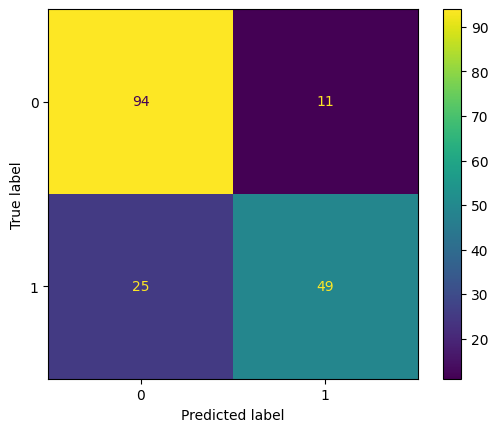

In [60]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
cf = confusion_matrix(ytest, ypred_ts)
cfd = ConfusionMatrixDisplay(cf, display_labels=c)
cfd.plot()

In [61]:
from sklearn.metrics import classification_report
print(classification_report(ytest, ypred_ts))

              precision    recall  f1-score   support

           0       0.79      0.90      0.84       105
           1       0.82      0.66      0.73        74

    accuracy                           0.80       179
   macro avg       0.80      0.78      0.79       179
weighted avg       0.80      0.80      0.79       179



### Predicting out of sample Data

In [63]:
xnew = pd.read_csv('test_titanic.csv')
xnew.head()

,PassengerId,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,892,3,"Kelly, Mr. James",male,34.5,0,0,330911,7.8292,NaN,Q
1,893,3,"Wilkes, Mrs. James (Ellen Needs)",female,47.0,1,0,363272,7.0000,NaN,S
2,894,2,"Myles, Mr. Thomas Francis",male,62.0,0,0,240276,9.6875,NaN,Q
3,895,3,"Wirz, Mr. Albert",male,27.0,0,0,315154,8.6625,NaN,S
4,896,3,"Hirvonen, Mrs. Alexander (Helga E Lindqvist)",female,22.0,1,1,3101298,12.2875,NaN,S


In [64]:
xnew.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 418 entries, 0 to 417
Data columns (total 11 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   PassengerId  418 non-null    int64  
 1   Pclass       418 non-null    int64  
 2   Name         418 non-null    object 
 3   Sex          418 non-null    object 
 4   Age          332 non-null    float64
 5   SibSp        418 non-null    int64  
 6   Parch        418 non-null    int64  
 7   Ticket       418 non-null    object 
 8   Fare         417 non-null    float64
 9   Cabin        91 non-null     object 
 10  Embarked     418 non-null    object 
dtypes: float64(2), int64(4), object(5)
memory usage: 36.1+ KB


In [67]:
b = xnew.isna().sum()
b[b>0]

Age       86
Fare       1
Cabin    327
dtype: int64

In [70]:
xnew.duplicated().sum()

0

In [72]:

xnew_pre = pre1.transform(xnew)
xnew_pre.head()

,num__Pclass,num__Parch,num__Fare,cat__Sex_female,cat__Sex_male,cat__Embarked_C,cat__Embarked_Q,cat__Embarked_S
0,0.827377,-0.473674,-0.490783,0.0,1.0,0.0,1.0,0.0
1,0.827377,-0.473674,-0.507479,1.0,0.0,0.0,0.0,1.0
2,-0.369365,-0.473674,-0.453367,0.0,1.0,0.0,1.0,0.0
3,0.827377,-0.473674,-0.474005,0.0,1.0,0.0,0.0,1.0
4,0.827377,0.767630,-0.401017,1.0,0.0,0.0,0.0,1.0


### Predict The Results

In [73]:
preds = best_rfc.predict(xnew_pre)
preds

array([0, 0, 0, 0, 1, 0, 1, 0, 1, 0, 0, 0, 1, 0, 1, 1, 0, 0, 0, 1, 0, 0,
       1, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1,
       1, 0, 0, 0, 1, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 1,
       1, 0, 0, 1, 1, 0, 0, 0, 1, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0,
       1, 0, 1, 0, 1, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0,
       0, 1, 1, 1, 1, 0, 0, 1, 0, 1, 1, 0, 1, 0, 0, 1, 0, 1, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0,
       0, 0, 1, 0, 0, 0, 1, 0, 1, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1,
       1, 0, 1, 1, 0, 0, 1, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0,
       0, 0, 1, 0, 0, 1, 0, 0, 1, 0, 1, 0, 0, 0, 0, 1, 1, 0, 1, 0, 1, 0,
       1, 0, 1, 0, 1, 1, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1,
       1, 0, 0, 0, 1, 0, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 1,
       0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 1, 0, 0, 0, 0, 0, 0, 1, 1, 1, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0,

In [77]:
probs = best_rfc.predict_proba(xnew_pre)[:,1]
probs

array([0.14773787, 0.49514599, 0.21010561, 0.14321863, 0.53120571,
       0.14321863, 0.5213819 , 0.28373766, 0.63551729, 0.20339772,
       0.13332952, 0.29109905, 0.94210799, 0.22064213, 0.79743248,
       0.81300811, 0.21893638, 0.16363641, 0.44258189, 0.64891442,
       0.35810859, 0.15767731, 0.77941048, 0.32090062, 0.88858376,
       0.20339772, 0.94766495, 0.16363641, 0.30400378, 0.19984301,
       0.22064213, 0.23354686, 0.46845605, 0.4149634 , 0.35810859,
       0.15023928, 0.39829617, 0.39829617, 0.14321863, 0.23599612,
       0.399032  , 0.30400378, 0.13332952, 0.75698622, 0.79743248,
       0.14321863, 0.34354086, 0.14773787, 0.96121908, 0.46845605,
       0.31857152, 0.1974314 , 0.82020048, 0.88180753, 0.1974314 ,
       0.15847976, 0.13332952, 0.13332952, 0.20339772, 0.96121908,
       0.13332952, 0.22064213, 0.13332952, 0.6163819 , 0.43151709,
       0.75698622, 0.6163819 , 0.30400378, 0.34354086, 0.81180753,
       0.6163819 , 0.13332952, 0.44258189, 0.34354086, 0.96121

### Create final Dataframe

In [78]:
df_final = xnew[['PassengerId']]
df_final

,PassengerId
0,892
1,893
2,894
3,895
4,896
...,...
413,1305
414,1306
415,1307
416,1308


In [79]:
df_final['Survived_preds'] = preds
df_final['Survived_probs'] = probs

In [80]:
df_final

,PassengerId,Survived_preds,Survived_probs
0,892,0,0.147738
1,893,0,0.495146
2,894,0,0.210106
3,895,0,0.143219
4,896,1,0.531206
...,...,...,...
413,1305,0,0.143219
414,1306,1,0.961219
415,1307,0,0.133330
416,1308,0,0.143219


In [81]:
df_final['Survived_probs'] = df_final['Survived_probs'].apply(round,args=(4,))
df_final

,PassengerId,Survived_preds,Survived_probs
0,892,0,0.1477
1,893,0,0.4951
2,894,0,0.2101
3,895,0,0.1432
4,896,1,0.5312
...,...,...,...
413,1305,0,0.1432
414,1306,1,0.9612
415,1307,0,0.1333
416,1308,0,0.1432


In [83]:
df_final['Survived_preds'].value_counts()

Survived_preds
0    293
1    125
Name: count, dtype: int64

<Axes: xlabel='Survived_preds'>

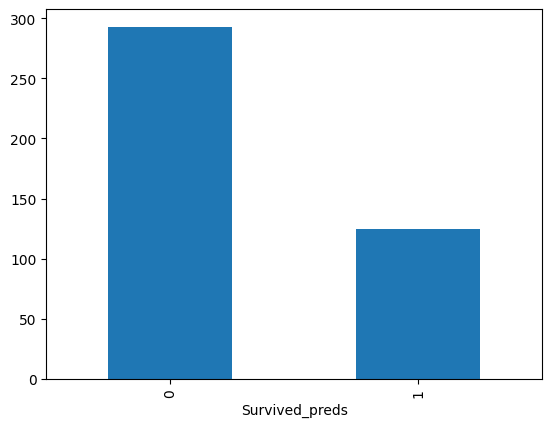

In [84]:
df_final['Survived_preds'].value_counts().plot(kind='bar')

### Save above results 

In [82]:
df_final.to_csv('Results.csv',index= False)